In [2]:
from model.ctabgan import CTABGAN
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics
import numpy as np
import pandas as pd
import glob
import logging

In [3]:
logger = logging.getLogger()
formatter = logging.Formatter(
    "[%(asctime)s][%(name)s:%(lineno)d][%(levelname)s] - %(message)s"
)
streamHandler = logging.StreamHandler()
streamHandler.setFormatter(formatter)
logger.addHandler(streamHandler)
logger.setLevel(logging.INFO)

num_exp = 1
dataset = "Adult"
real_path = "Real_Datasets/Adult.csv"
fake_file_root = "Fake_Datasets"

In [ ]:
# log_columns 직접 넣어줘야 하는듯?
# 컬럼 타입이나, mixed 등등도 전부


synthesizer =  CTABGAN(raw_csv_path = real_path,
                 test_ratio = 0.20,
                 categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income'], 
                 log_columns = [],
                 mixed_columns= {'capital-loss':[0.0],'capital-gain':[0.0]},
                 general_columns = ["age"],
                #  non_categorical_columns = [],
                 integer_columns = ['age', 'fnlwgt','capital-gain', 'capital-loss','hours-per-week'],
                 problem_type= {"Classification": 'income'}) 

for i in range(num_exp):
    synthesizer.fit()
    # syn = synthesizer.generate_samples()
    # syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

[2023-08-10 17:53:08,372][root:62][INFO] - [CTABGAN]: build data preprocessor start
[2023-08-10 17:53:08,394][root:75][INFO] - [CTABGAN]: build data preprocessor end
[2023-08-10 17:53:08,395][root:76][INFO] - [CTABGAN]: fit synthesizer start
[2023-08-10 17:53:08,395][root:481][INFO] - [CTAB-SYN]: fit data transformer start
[2023-08-10 17:53:08,396][root:33][INFO] - [Transformer]: get metadata ...


  0%|          | 0/14 [00:00<?, ?it/s]

[2023-08-10 17:53:08,421][root:96][INFO] - [Transformer]: fitting start ...


  0%|          | 0/14 [00:00<?, ?it/s]

[2023-08-10 17:53:16,767][root:221][INFO] - [Transformer]: fitting end ...
[2023-08-10 17:53:16,771][root:490][INFO] - [CTAB-SYN]: fit data transformer end
[2023-08-10 17:53:16,788][root:491][INFO] - [CTAB-SYN]: now transform data start
[2023-08-10 17:53:18,120][root:493][INFO] - [CTAB-SYN]: now transform data end


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

In [ ]:
syn = synthesizer.generate_samples()
syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

In [5]:
synthesizer.synthesizer.transformer.output_info

[(1, 'tanh', 'yes_g'),
 (9, 'softmax'),
 (1, 'tanh', 'no_g'),
 (9, 'softmax'),
 (16, 'softmax'),
 (7, 'softmax'),
 (15, 'softmax'),
 (6, 'softmax'),
 (5, 'softmax'),
 (2, 'softmax'),
 (1, 'tanh', 'no_g'),
 (6, 'softmax'),
 (1, 'tanh', 'no_g'),
 (8, 'softmax'),
 (1, 'tanh', 'no_g'),
 (9, 'softmax'),
 (42, 'softmax'),
 (2, 'softmax')]

In [6]:
synthesizer.data_prep.df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,4,0,3,4,0,0,0,30,39,0


In [7]:
synthesizer.data_prep.label_encoder_list  #[1]['label_encoder'].__dict__

[{'column': 'workclass', 'label_encoder': LabelEncoder()},
 {'column': 'education', 'label_encoder': LabelEncoder()},
 {'column': 'marital-status', 'label_encoder': LabelEncoder()},
 {'column': 'occupation', 'label_encoder': LabelEncoder()},
 {'column': 'relationship', 'label_encoder': LabelEncoder()},
 {'column': 'race', 'label_encoder': LabelEncoder()},
 {'column': 'gender', 'label_encoder': LabelEncoder()},
 {'column': 'native-country', 'label_encoder': LabelEncoder()},
 {'column': 'income', 'label_encoder': LabelEncoder()}]

---
## evaluation

In [8]:
fake_paths = glob.glob(fake_file_root+"/"+dataset+"/"+"*")
fake_paths

['Fake_Datasets/Adult/Adult_fake_0.csv']

In [9]:
%%time
classifiers_list = ["lr","dt","rf","mlp"]
result_mat = get_utility_metrics(real_path,fake_paths,"MinMax",classifiers_list, test_ratio = 0.20)

result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = classifiers_list
result_df

CPU times: user 2min 52s, sys: 18.8 s, total: 3min 11s
Wall time: 27.3 s


,Acc,AUC,F1_Score
lr,4.370969,0.394651,0.220331
dt,23.267479,0.276501,0.274521
rf,10.185280,0.443863,0.363904
mlp,7.892312,0.412079,0.330745


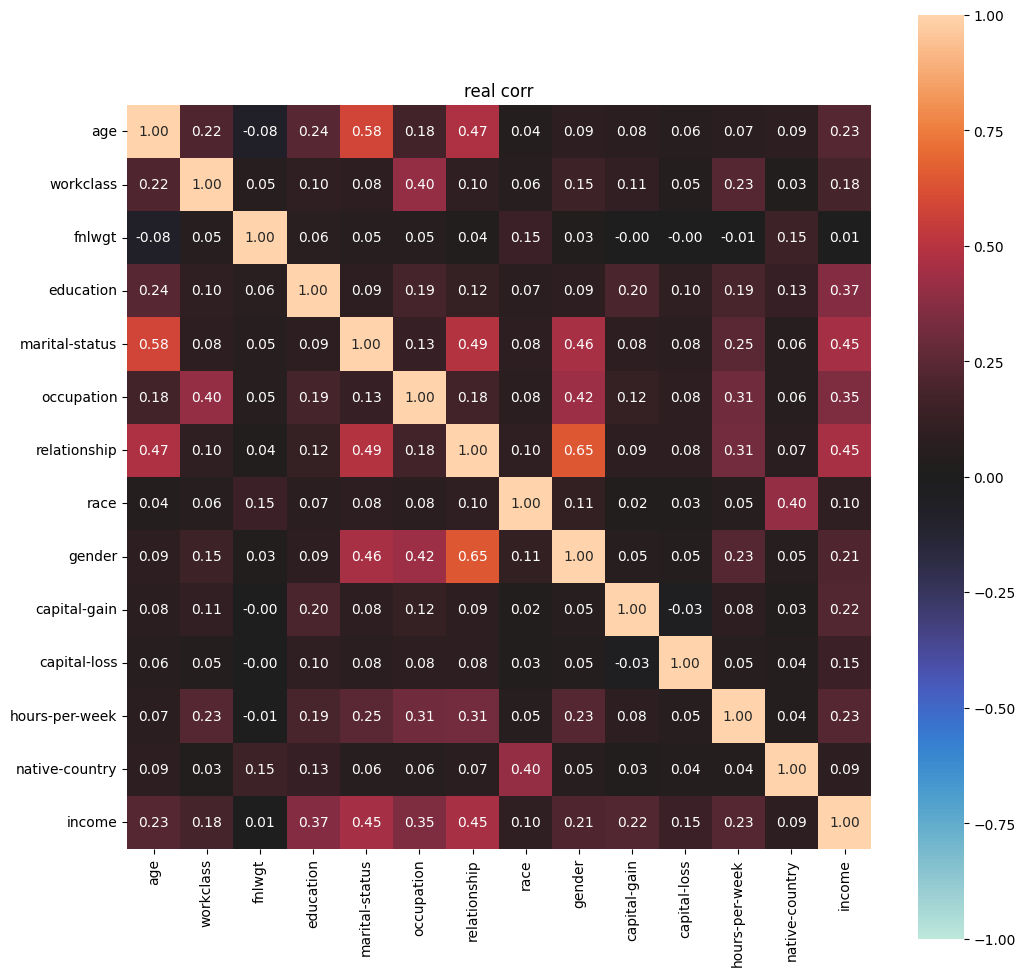

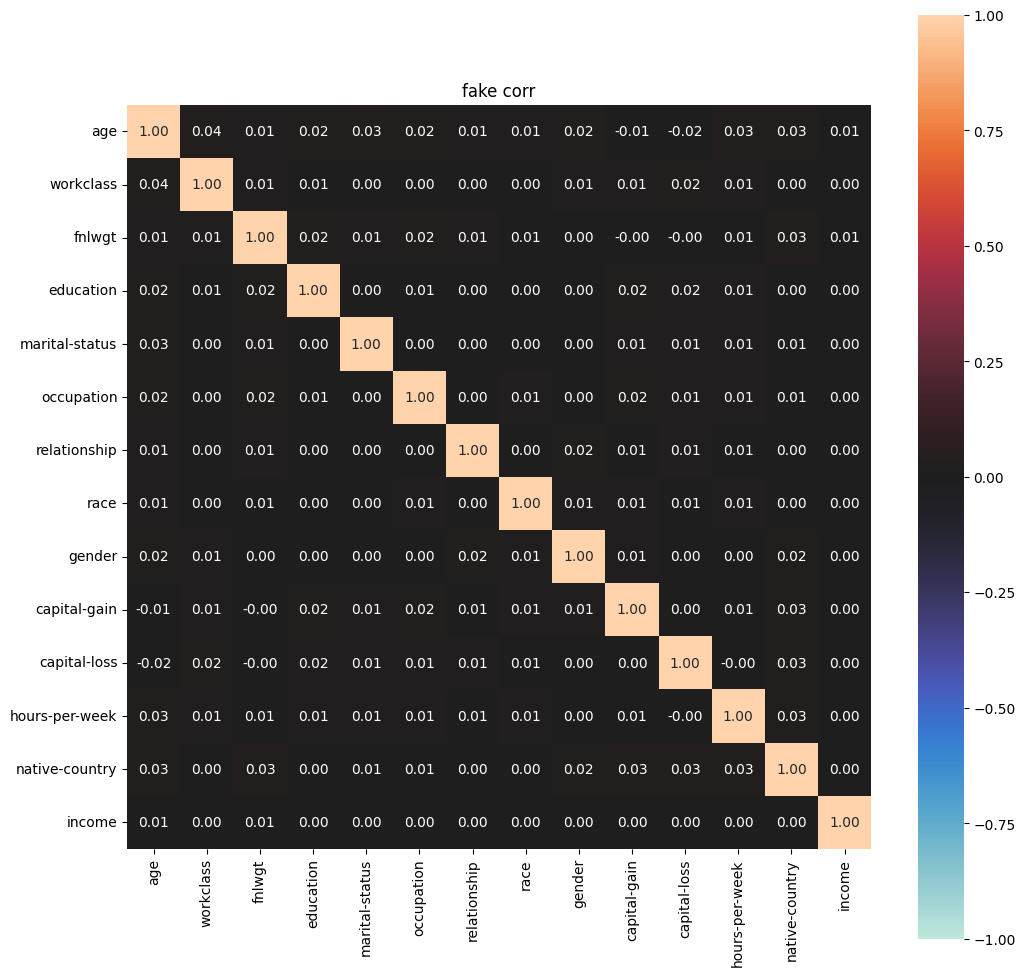

CPU times: user 2.57 s, sys: 1.68 s, total: 4.25 s
Wall time: 1.27 s


,Average WD (Continuous Columns,Average JSD (Categorical Columns),Correlation Distance
0,0.043742,0.206307,2.705761


In [10]:
%%time
adult_categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
stat_res_avg = []
for fake_path in fake_paths:
    stat_res = stat_sim(real_path,fake_path,adult_categorical)
    stat_res_avg.append(stat_res)

stat_columns = ["Average WD (Continuous Columns","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res_avg).mean(axis=0).reshape(1,3),columns=stat_columns)
stat_results

In [11]:
%%time
priv_res_avg = []
for fake_path in fake_paths:
    priv_res = privacy_metrics(real_path,fake_path)
    priv_res_avg.append(priv_res)
    
privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res_avg).mean(axis=0).reshape(1,6),columns=privacy_columns)
privacy_results

CPU times: user 10.3 s, sys: 1.3 s, total: 11.6 s
Wall time: 10.6 s


,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,0.893437,0.216545,0.710674,0.712195,0.442052,0.623856


---
## dev

In [50]:
synthesizer.data_prep.df.workclass.value_counts().index.tolist()

[4, 6, 2, 0, 7, 5, 1, 8, 3]

In [54]:
for i in range(8):
    xx = synthesizer.data_prep.df.workclass.value_counts().index.tolist().__getitem__(i)
    print(xx)

4
6
2
0
7
5
1
8


In [55]:
synthesizer.data_prep.df.workclass.unique().tolist()

[4, 0, 1, 2, 7, 6, 5, 3, 8]

In [13]:
len(np.zeros((2,3)))

2

In [65]:
[3,2,1]*-1

[]

In [70]:
np.argsort(np.array([3,2,1])*(-1))

array([0, 1, 2])

In [78]:
dd = synthesizer.synthesizer.transformer.transform(synthesizer.data_prep.df.values)

In [80]:
dd.shape

(39073, 142)

In [86]:
dd[0].round(3)

array([ 0.479,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   , -0.299,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,
        1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.232,
        0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      

In [87]:
synthesizer.synthesizer.transformer.model

[None,
 None,
 BayesianGaussianMixture(n_components=10, random_state=42,
                         weight_concentration_prior=0.001),
 None,
 None,
 None,
 None,
 None,
 None,
 (BayesianGaussianMixture(n_components=10, random_state=42,
                          weight_concentration_prior=0.001),
  BayesianGaussianMixture(n_components=10, random_state=42,
                          weight_concentration_prior=0.001)),
 (BayesianGaussianMixture(n_components=10, random_state=42,
                          weight_concentration_prior=0.001),
  BayesianGaussianMixture(n_components=10, random_state=42,
                          weight_concentration_prior=0.001)),
 BayesianGaussianMixture(n_components=10, random_state=42,
                         weight_concentration_prior=0.001),
 None,
 None]

In [88]:
synthesizer.synthesizer.transformer.output_info

[(1, 'tanh', 'yes_g'),
 (9, 'softmax'),
 (1, 'tanh', 'no_g'),
 (9, 'softmax'),
 (16, 'softmax'),
 (7, 'softmax'),
 (15, 'softmax'),
 (6, 'softmax'),
 (5, 'softmax'),
 (2, 'softmax'),
 (1, 'tanh', 'no_g'),
 (6, 'softmax'),
 (1, 'tanh', 'no_g'),
 (8, 'softmax'),
 (1, 'tanh', 'no_g'),
 (10, 'softmax'),
 (42, 'softmax'),
 (2, 'softmax')]